In [1]:
import torch
import sys
sys.path.insert(0,'/scratch/mcesped/code/NoiseDetection_iEEG/interictal_classifier/')
import model
import data_setup
import utils
import os
import numpy as np
from matplotlib import pyplot


# Functions

In [2]:
import sklearn.metrics as skm

def classication_metrics_binary(y_true, y_pred_class):
    """
    Args:
      y_true: Ground truth (correct) labels.
      y_pred: Array of probability estimates provided by the model.

    Missing: AUPRC https://towardsdatascience.com/imbalanced-data-stop-using-roc-auc-and-use-auprc-instead-46af4910a494
    """
    # Compute accuracy
    acc = skm.accuracy_score(y_true, y_pred_class)
    balanced_acc = skm.balanced_accuracy_score(y_true, y_pred_class)
    # Compute precision
    # https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
    prec = skm.precision_score(y_true, y_pred_class, average="binary", zero_division=0.0)
    # Recall
    recall = skm.recall_score(y_true, y_pred_class, average="binary", zero_division=0.0)
    # F1
    f1 = skm.f1_score(y_true, y_pred_class, average="binary", zero_division=0.0)
    # Assign to list
    sensitivity = skm.recall_score(y_true , y_pred_class)
    specificity = skm.recall_score(np.logical_not(y_true) , np.logical_not(y_pred_class))
    gmeans = sqrt(sensitivity * specificity)

    print(f"""
    Accuracy: {acc:.3f} \n
    Balanced accuracy: {balanced_acc:.3f} \n
    F1: {f1:.3f} \n
    Precision: {prec:.3f} \n
    Recall/Sensitivity: {recall:.3f} \n
    Specificity: {specificity:.3f} \n
    G-means: {gmeans:.3f} \n
    """)

    confusion_matrix = skm.confusion_matrix(y_true, y_pred_class)

    cm_display = skm.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    
    cm_display.plot()
    pyplot.show() 

In [3]:
def classify_matrix(y_pred, thr_1, thr_2):
    # Use argmax
    results = np.argmax(y_pred, axis=1)
    # Update those below thr
    condition_clean = np.logical_and(y_pred[:, 0] <= thr_1, y_pred[:, 1] <= thr_2)
    results[condition_clean] = 2
    # # Check conditions using vectorized operations
    # condition_phys = np.logical_and(matrix[:, 0] == 0, matrix[:, 1] == 0)
    # condition_art = np.logical_and(matrix[:, 0] == 1, matrix[:, 1] == 0)
    # condition_path = np.logical_and(matrix[:, 0] == 0, matrix[:, 1] == 1)
    # condition_undefined = np.logical_and(matrix[:, 0] == 1, matrix[:, 1] == 1)
    
    # Initialize an array to store results
    # results = np.empty(matrix.shape[0])  # Adjust the dtype according to the length of the longest label
    
    # # Assign labels based on conditions
    # results[condition_phys] = 2
    # results[condition_art] = 0
    # results[condition_path] = 1
    # results[condition_undefined] = -1
    
    return results


# Multiclass 2048 Hz

In [6]:
# load dataset
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [7]:
# Zip files and transforms
features = 'Hilbert'
srate=2048
zip_files = [
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Fnusa_Combined.zip",
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Mayo_Combined.zip",
]
df_train_path = '/scratch/mcesped/Datasets/Multiclass/df_train_curated.csv'
df_val_path = '/scratch/mcesped/Datasets/Multiclass/df_val_full.csv'

In [8]:
(
        train_dataloader,
        val_dataloader,
        _,
    ) = data_setup.create_dataloaders_uncompress(
        zip_files,
        df_train_path,
        df_val_path,
        None,
        None,
        batch_size=32,
        num_workers=4,
        dataset_class="SpectrogramDir",
        binary=False,
        previosly_uncompressed = False,
        features=features
    )
train_dataloader, val_dataloader 

Percentage df train: 0.35165891969866964


Uncompressing data..

Creating dataset classes...


(<torch.utils.data.dataloader.DataLoader at 0x2b3844203100>,
 <torch.utils.data.dataloader.DataLoader at 0x2b384a586500>)

## Trial 3
CNN_Long_Data3
Using  full fnusa as training and curated mayo as val
Using Hilbert feature

Mayo

max_img_subj_cat = {
    'noise': 35%, # Pay more the noise
    'path': 30%, # Less path at it is not so hard to identify
    'phys': 35%
}

In [5]:
n_classes = 3
input_size = 1
model_0 = model.CNN_Long_Data3(n_classes=n_classes, input_size=input_size, input_length=6094)

In [6]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/MultiClass/2048Hz/trial_3/best_model.pt"))

<All keys matched successfully>

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target deviceval_metrics
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, np.argmax(y_pred_prob.detach().numpy(), axis=1)]
        )

y_total.shape, y_pred_total.shape

((46520,), (46520,))

In [8]:
t_metrics = utils.classication_metrics(y_total, y_pred_total, test=True)
print(f"\nVal metrics:", end="\n", flush=True)
utils.print_key_metrics(
    *t_metrics
)


Val metrics:

-------------------- Key Metrics --------------------

Accuracy: 0.73
Balanced Accuracy: 0.73

Micro Precision: 0.73
Micro Recall: 0.73
Micro F1-score: 0.73

Macro Precision: 0.74
Macro Recall: 0.73
Macro F1-score: 0.73

Weighted Precision: 0.73
Weighted Recall: 0.73
Weighted F1-score: 0.73

--------------- Classification Report ---------------

              precision    recall  f1-score   support

         0.0       0.70      0.78      0.74     16305
         1.0       0.87      0.78      0.82     13953
         2.0       0.65      0.63      0.64     16262

    accuracy                           0.73     46520
   macro avg       0.74      0.73      0.73     46520
weighted avg       0.73      0.73      0.73     46520



## Trial 8
CNN_Long_Data3
Using  full fnusa as training and full mayo as val
Using Hilbert feature

In [9]:
n_classes = 3
input_size = 1
model_0 = model.CNN_Long_Data3(n_classes=n_classes, input_size=input_size, input_length=6094)

In [10]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/MultiClass/2048Hz/trial_8/best_model.pt"))

<All keys matched successfully>

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target deviceval_metrics
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, np.argmax(y_pred_prob.detach().numpy(), axis=1)]
        )

y_total.shape, y_pred_total.shape

((46520,), (46520,))

In [12]:
t_metrics = utils.classication_metrics(y_total, y_pred_total, test=True)
print(f"\nVal metrics:", end="\n", flush=True)
utils.print_key_metrics(
    *t_metrics
)


Val metrics:

-------------------- Key Metrics --------------------

Accuracy: 0.71
Balanced Accuracy: 0.71

Micro Precision: 0.71
Micro Recall: 0.71
Micro F1-score: 0.71

Macro Precision: 0.75
Macro Recall: 0.71
Macro F1-score: 0.72

Weighted Precision: 0.74
Weighted Recall: 0.71
Weighted F1-score: 0.72

--------------- Classification Report ---------------

              precision    recall  f1-score   support

         0.0       0.75      0.69      0.72     16305
         1.0       0.93      0.67      0.78     13953
         2.0       0.58      0.76      0.66     16262

    accuracy                           0.71     46520
   macro avg       0.75      0.71      0.72     46520
weighted avg       0.74      0.71      0.72     46520



# Noise detection 1024 Hz

In [3]:
# load dataset
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [4]:
# Zip files and transforms
features = 'Combined'
srate=1024
zip_files = [
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Fnusa_Combined.zip",
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Mayo_Combined.zip",
]
df_train_path = '/scratch/mcesped/Datasets/Noise_detection/df_train_curated.csv'
df_val_path = '/scratch/mcesped/Datasets/Noise_detection/df_val_curated.csv'

In [5]:
(
        train_dataloader,
        val_dataloader,
        _,
    ) = data_setup.create_dataloaders_uncompress(
        zip_files,
        df_train_path,
        df_val_path,
        None,
        None,
        batch_size=32,
        num_workers=4,
        dataset_class="SpectrogramDir",
        binary=True,
        previosly_uncompressed = False,
        features=features
    )
train_dataloader, val_dataloader 

Percentage df train: 0.5102144921903466

Grouping Pathology and physiology in one class


Uncompressing data..

Creating dataset classes...


(<torch.utils.data.dataloader.DataLoader at 0x2ae63483c5e0>,
 <torch.utils.data.dataloader.DataLoader at 0x2ae6ebd36200>)

## Trial 1
CNN_Long_Data2
Using  curated fnusa as training and curated mayo as val
Using Hilbert feature

Fnusa

max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1500
}

Mayo

max_img_subj_cat = {
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1300
}

In [12]:
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data2(n_classes=n_classes, input_size=input_size, input_length=3046)

In [13]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/1024Hz/trial_1/best_model.pt"))

<All keys matched successfully>

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((40326,), (40326,))

### ROC

Best Threshold=0.406871, G-Mean=0.798, Specificity=0.794, Sensitivity=0.803


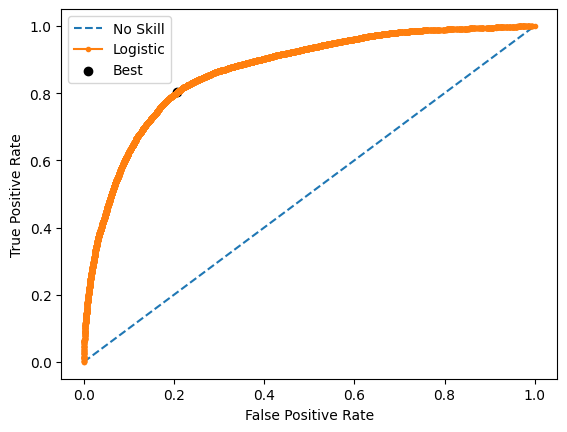

In [15]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.798 

    Balanced accuracy: 0.798 

    F1: 0.798 

    Precision: 0.793 

    Recall/Sensitivity: 0.803 

    Specificity: 0.794 

    G-means: 0.798 

    


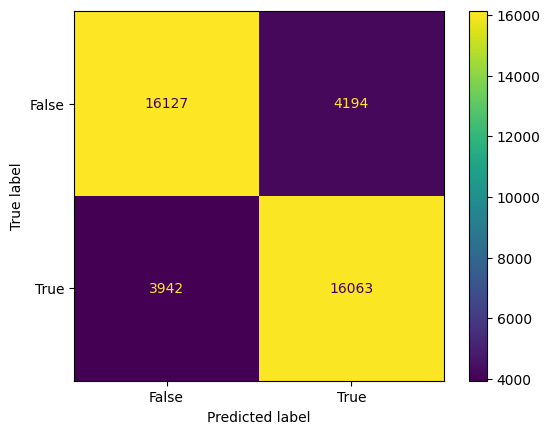

In [16]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1

Best Threshold=0.344618, F-Score=0.801, Recall:0.836, Precision:0.769


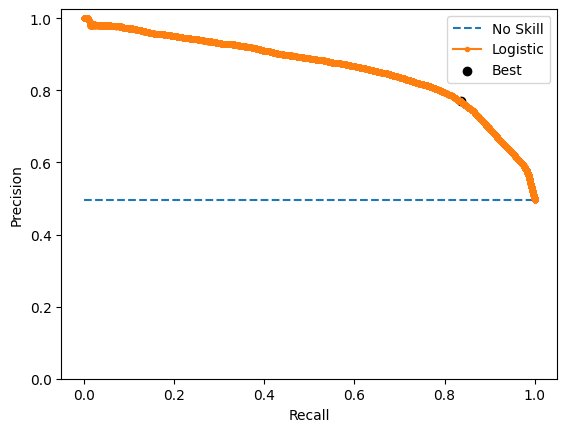

In [17]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.794 

    Balanced accuracy: 0.795 

    F1: 0.801 

    Precision: 0.769 

    Recall/Sensitivity: 0.836 

    Specificity: 0.753 

    G-means: 0.793 

    


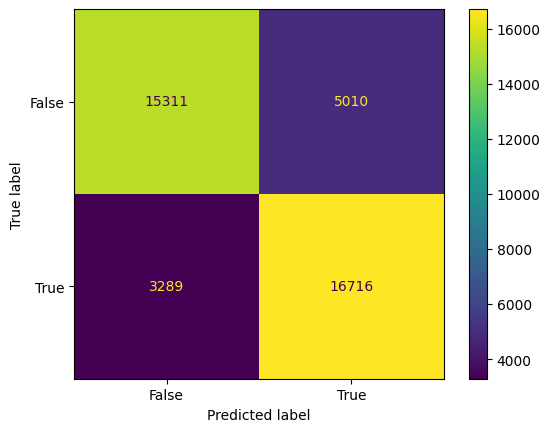

In [18]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Average


    Accuracy: 0.797 

    Balanced accuracy: 0.797 

    F1: 0.800 

    Precision: 0.781 

    Recall/Sensitivity: 0.820 

    Specificity: 0.774 

    G-means: 0.797 

    


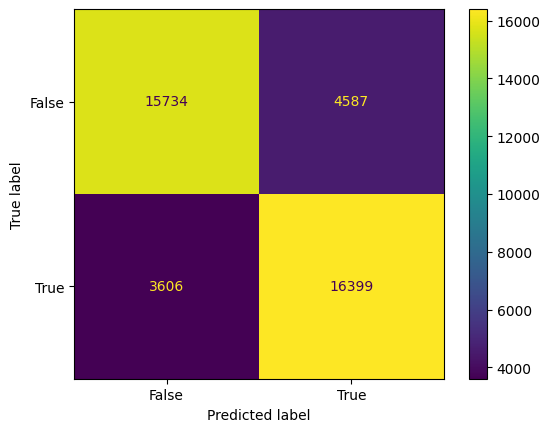

In [19]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 2
CNN_Long_Data3
Using  curated fnusa as training and curated mayo as val
Using Hilbert feature

Fnusa

max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1500
}

Mayo

max_img_subj_cat = {
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1300
}

In [28]:
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data3(n_classes=n_classes, input_size=input_size, input_length=3046)

In [29]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/1024Hz/trial_2/best_model.pt"))

<All keys matched successfully>

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((40326,), (40326,))

### ROC

Best Threshold=0.475517, G-Mean=0.811, Specificity=0.783, Sensitivity=0.841


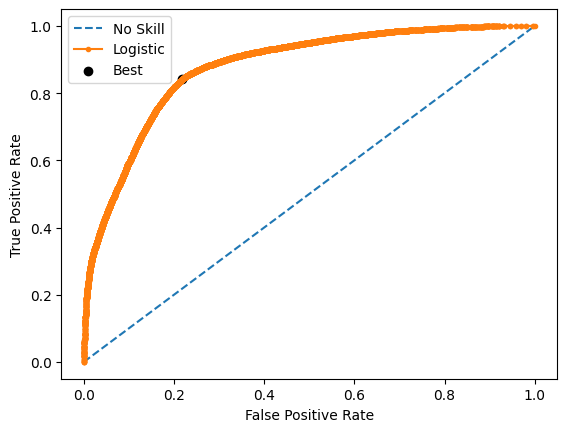

In [31]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.812 

    Balanced accuracy: 0.812 

    F1: 0.816 

    Precision: 0.792 

    Recall/Sensitivity: 0.841 

    Specificity: 0.783 

    G-means: 0.811 

    


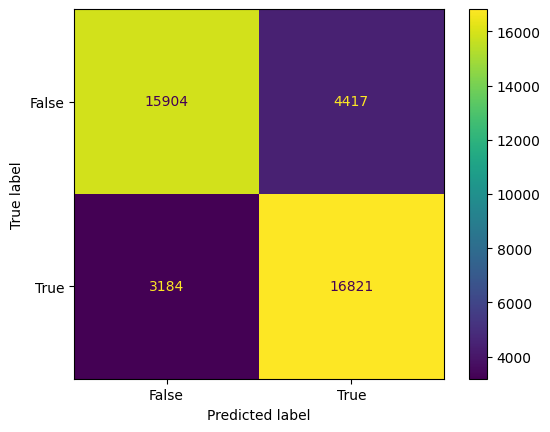

In [32]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1

Best Threshold=0.430638, F-Score=0.818, Recall:0.857, Precision:0.782


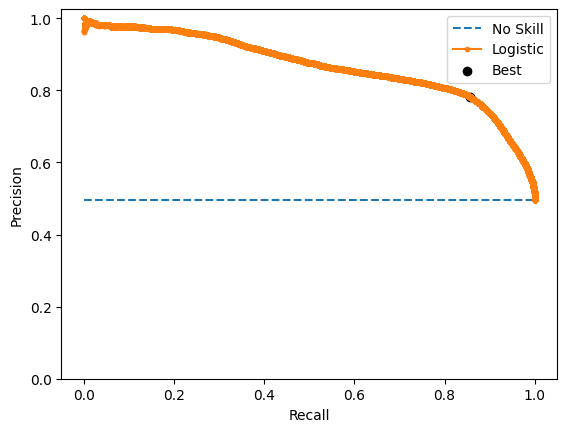

In [33]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.810 

    Balanced accuracy: 0.811 

    F1: 0.818 

    Precision: 0.782 

    Recall/Sensitivity: 0.857 

    Specificity: 0.765 

    G-means: 0.810 

    


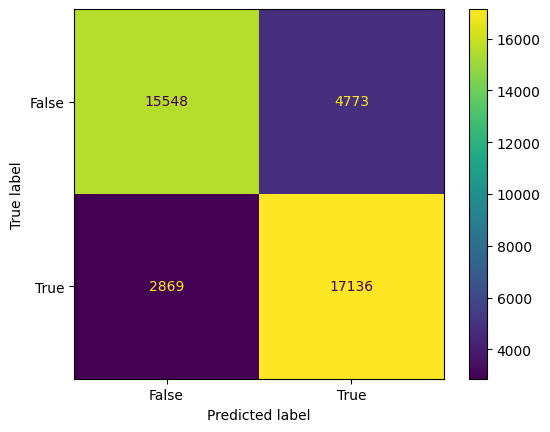

In [34]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Average


    Accuracy: 0.811 

    Balanced accuracy: 0.812 

    F1: 0.817 

    Precision: 0.787 

    Recall/Sensitivity: 0.849 

    Specificity: 0.774 

    G-means: 0.811 

    


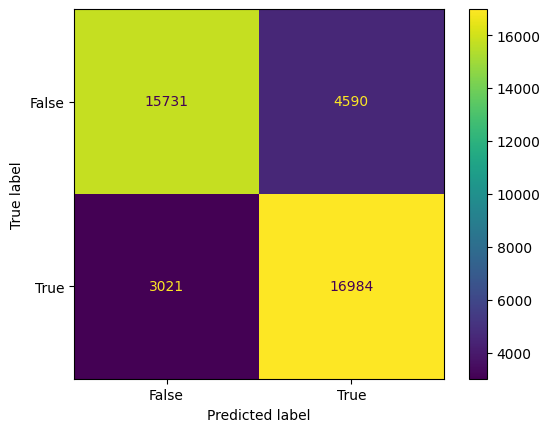

In [35]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 3
CNN_Long_Data5
Using  curated fnusa as training and curated mayo as val
Using Hilbert feature

Fnusa

max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1500
}

Mayo

max_img_subj_cat = {
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1300
}

In [36]:
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data5(n_classes=n_classes, input_size=input_size, input_length=3046)

In [37]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/1024Hz/trial_3/best_model.pt"))

<All keys matched successfully>

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((40326,), (40326,))

### ROC

Best Threshold=0.521760, G-Mean=0.801, Specificity=0.781, Sensitivity=0.823


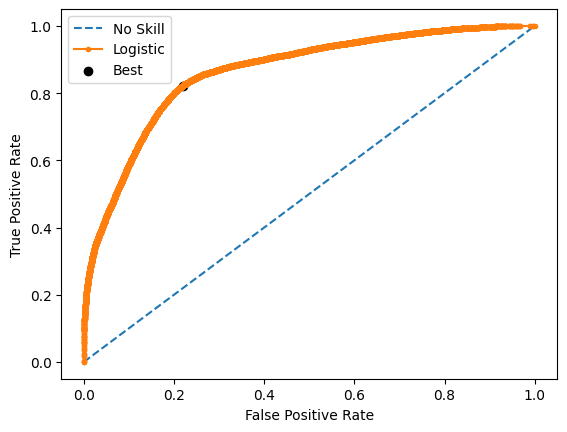

In [39]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.801 

    Balanced accuracy: 0.802 

    F1: 0.804 

    Precision: 0.787 

    Recall/Sensitivity: 0.822 

    Specificity: 0.781 

    G-means: 0.801 

    


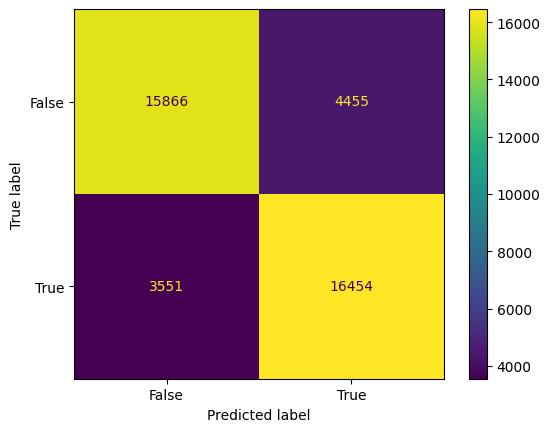

In [40]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1

Best Threshold=0.484637, F-Score=0.806, Recall:0.839, Precision:0.775


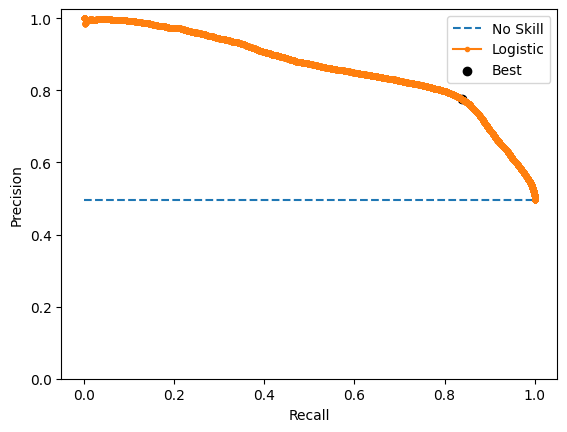

In [41]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.799 

    Balanced accuracy: 0.800 

    F1: 0.806 

    Precision: 0.775 

    Recall/Sensitivity: 0.839 

    Specificity: 0.760 

    G-means: 0.799 

    


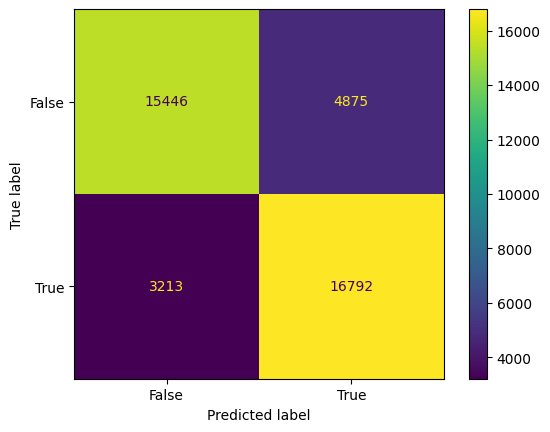

In [42]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Average


    Accuracy: 0.801 

    Balanced accuracy: 0.801 

    F1: 0.805 

    Precision: 0.781 

    Recall/Sensitivity: 0.832 

    Specificity: 0.770 

    G-means: 0.800 

    


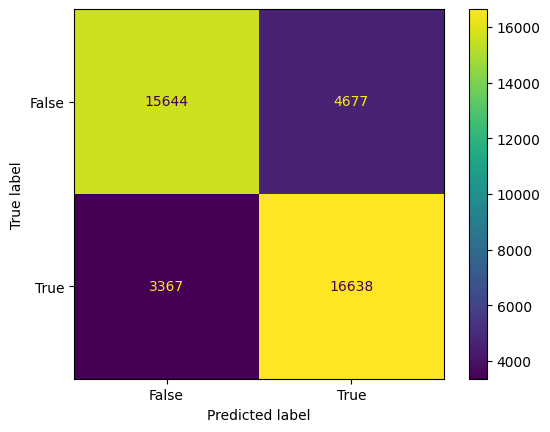

In [43]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 4
CNN_Long_Data
Using  curated fnusa as training and curated mayo as val
Using Hilbert feature

Fnusa

max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1500
}

Mayo

max_img_subj_cat = {
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1300
}

In [6]:
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data(n_classes=n_classes, input_size=input_size, input_length=3046)

In [7]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/1024Hz/trial_4/best_model.pt"))

<All keys matched successfully>

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((40326,), (40326,))

### ROC

Best Threshold=0.495334, G-Mean=0.788, Specificity=0.778, Sensitivity=0.799


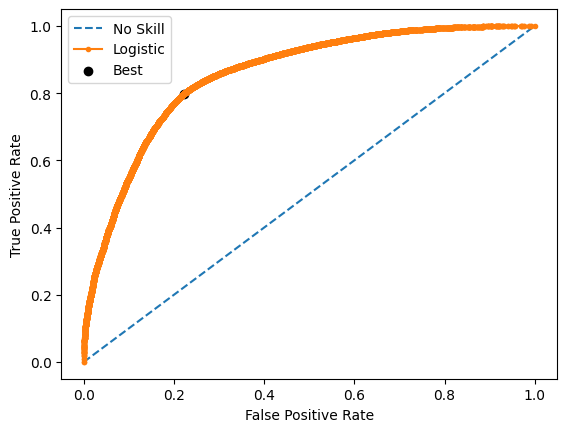

In [9]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.788 

    Balanced accuracy: 0.788 

    F1: 0.789 

    Precision: 0.780 

    Recall/Sensitivity: 0.799 

    Specificity: 0.778 

    G-means: 0.788 

    


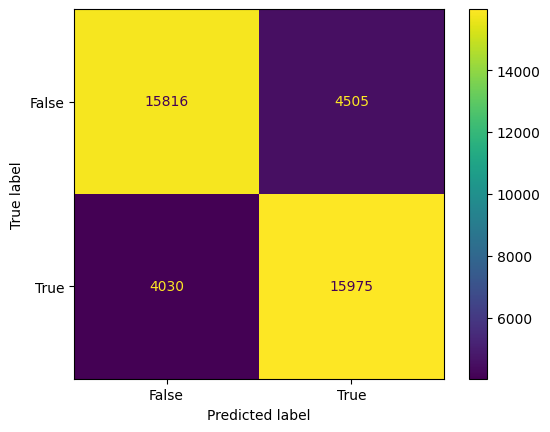

In [10]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1

Best Threshold=0.430006, F-Score=0.794, Recall:0.840, Precision:0.752


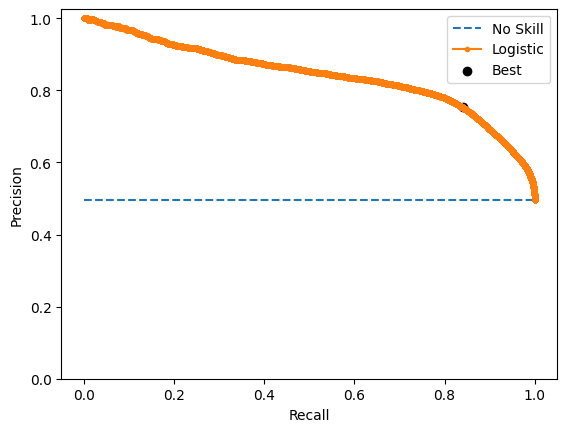

In [11]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.784 

    Balanced accuracy: 0.784 

    F1: 0.794 

    Precision: 0.752 

    Recall/Sensitivity: 0.840 

    Specificity: 0.728 

    G-means: 0.782 

    


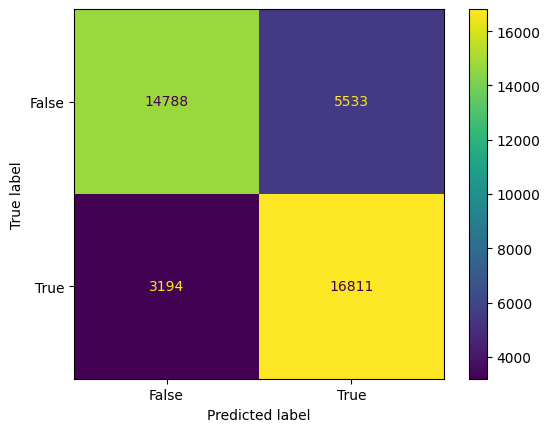

In [12]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Average


    Accuracy: 0.787 

    Balanced accuracy: 0.787 

    F1: 0.793 

    Precision: 0.766 

    Recall/Sensitivity: 0.821 

    Specificity: 0.753 

    G-means: 0.786 

    


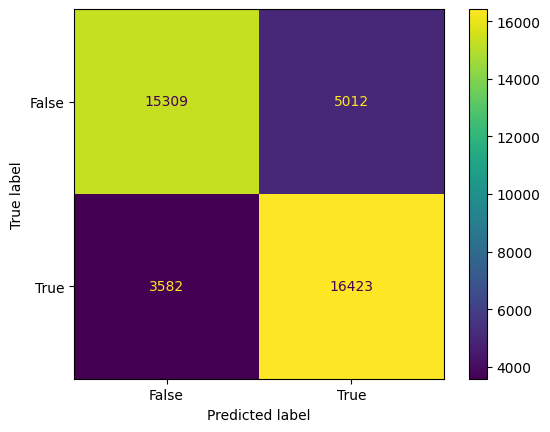

In [13]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 5
CNN_Long_Data3
Using  curated fnusa as training and curated mayo as val
Using Combined feature

Fnusa

max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1500
}

Mayo

max_img_subj_cat = {
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1300
}

In [12]:
n_classes = 1
input_size = 2
model_0 = model.CNN_Long_Data3(n_classes=n_classes, input_size=input_size, input_length=3046)

In [13]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/1024Hz/trial_5/best_model.pt"))

<All keys matched successfully>

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((40326,), (40326,))

### ROC

Best Threshold=0.484943, G-Mean=0.809, Specificity=0.786, Sensitivity=0.833


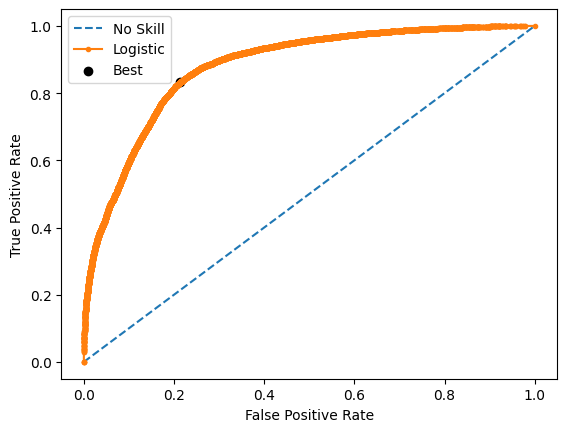

In [15]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.809 

    Balanced accuracy: 0.809 

    F1: 0.812 

    Precision: 0.793 

    Recall/Sensitivity: 0.833 

    Specificity: 0.786 

    G-means: 0.809 

    


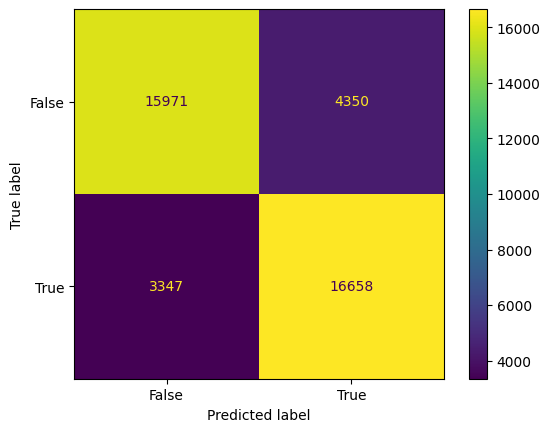

In [16]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1

Best Threshold=0.380956, F-Score=0.818, Recall:0.875, Precision:0.768


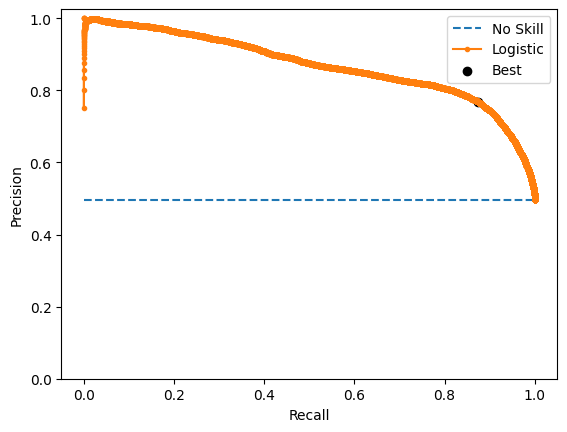

In [17]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.807 

    Balanced accuracy: 0.807 

    F1: 0.818 

    Precision: 0.768 

    Recall/Sensitivity: 0.875 

    Specificity: 0.739 

    G-means: 0.804 

    


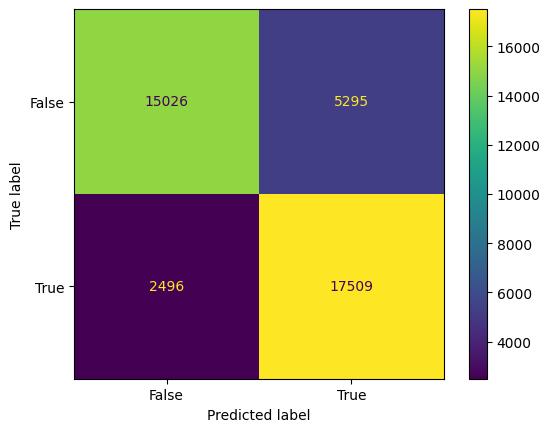

In [18]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Average


    Accuracy: 0.809 

    Balanced accuracy: 0.809 

    F1: 0.816 

    Precision: 0.781 

    Recall/Sensitivity: 0.853 

    Specificity: 0.765 

    G-means: 0.808 

    


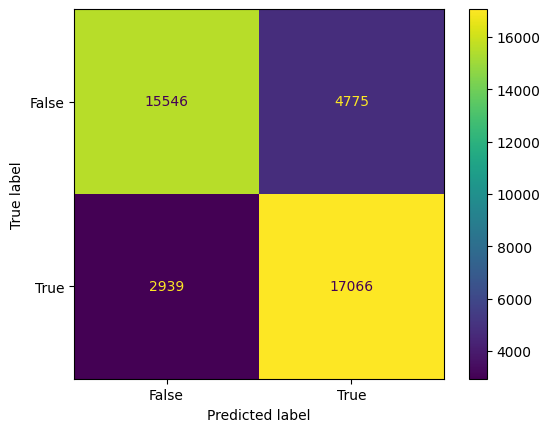

In [19]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 6
CNN_RNN_Long_Data
Using  curated fnusa as training and curated mayo as val
Using Combined feature

Fnusa

max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1500
}

Mayo

max_img_subj_cat = {
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1300
}

In [6]:
n_classes = 1
input_size = 1
model_0 = model.CNN_RNN_Long_Data(n_classes=n_classes, input_size=input_size, input_length=3046)

In [7]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/1024Hz/trial_6/best_model.pt"))

<All keys matched successfully>

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[32, 2, 5, 3046] to have 1 channels, but got 2 channels instead

### ROC

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1

In [ ]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Average

In [ ]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

# Noise detection 2048 Hz

In [2]:
# load dataset
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
# Zip files and transforms
features = 'Hilbert'
srate=2048
zip_files = [
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Fnusa_Combined.zip",
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Mayo_Combined.zip",
]
df_train_path = '/scratch/mcesped/Datasets/Noise_detection/df_train_curated.csv'
df_val_path = '/scratch/mcesped/Datasets/Noise_detection/df_val_curated.csv'

In [4]:
(
        train_dataloader,
        val_dataloader,
        _,
    ) = data_setup.create_dataloaders_uncompress(
        zip_files,
        df_train_path,
        df_val_path,
        None,
        None,
        batch_size=32,
        num_workers=4,
        dataset_class="SpectrogramDir",
        binary=True,
        previosly_uncompressed = False,
        features=features,
        binary_cat='Noise'
    )
train_dataloader, val_dataloader 

Percentage df train: 0.5102144921903466

Grouping Pathology and Physiology in one class


Uncompressing data..

Creating dataset classes...


(<torch.utils.data.dataloader.DataLoader at 0x2b4914fd6e60>,
 <torch.utils.data.dataloader.DataLoader at 0x2b49cad632b0>)

## Trial 11
CNN_Long_Data2
Using dataframe: /scratch/mcesped/Datasets/Noise_detection/df_train_curated.csv

Using zipfiles: ['/home/mcesped/scratch/Datasets/2048Hz/Dataset_Fnusa_Hilbert.zip', '/home/mcesped/scratch/Datasets/2048Hz/Dataset_Mayo_Hilbert.zip']

max_img_subj_cat = {
    'pw': 500, # Less the pw as it is easily identifiable
    'noise': 2000, # Pay more the noise
    'path': 1000, # Less path at it is not so hard to identify
    'phys': 1300
}

In [8]:
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data2(n_classes=n_classes, input_size=input_size, input_length=6094)

In [9]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/2048Hz/trial_11/best_model.pt"))

<All keys matched successfully>

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((10270,), (10270,))

In [12]:
y_pred_total

array([3.09198022e-01, 4.16526824e-01, 4.09560889e-01, ...,
       4.97195154e-01, 9.69519675e-01, 8.78338236e-04])

### Using ROC

In [13]:
from sklearn.metrics import roc_curve

In [14]:
testy = y_total
yhat = y_pred_total

Best Threshold=0.406050, G-Mean=0.820, Specificity=0.807, Sensitivity=0.834


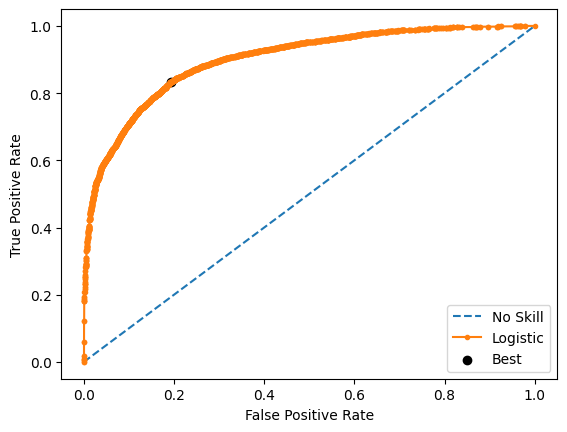

In [15]:
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax
# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

### Using Prec-Recall curve

In [16]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

Best Threshold=0.396133, F-Score=0.814, Recall:0.845, Precision:0.785


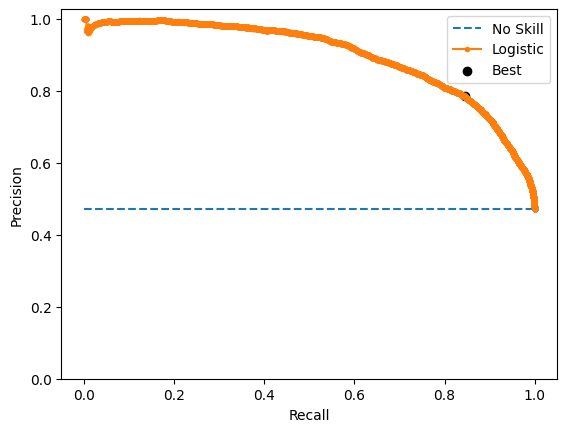

In [17]:
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

### Test both thresholds


    Accuracy: 0.820 

    Balanced accuracy: 0.820 

    F1: 0.813 

    Precision: 0.793 

    Recall: 0.834 

    Sensitivity: 0.834 

    Specificity: 0.807 

    G-means: 0.820 

    


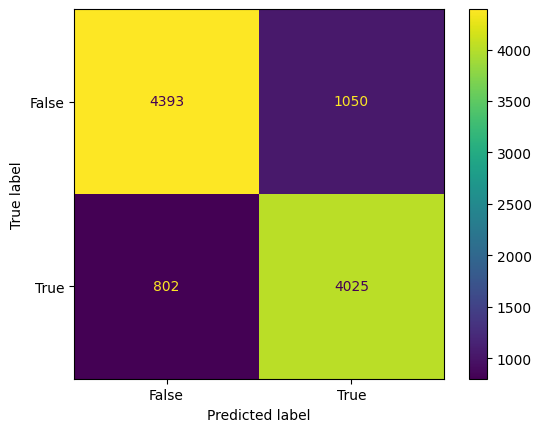

In [21]:
# ROC one
threshold_roc =  0.406050
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))


    Accuracy: 0.818 

    Balanced accuracy: 0.820 

    F1: 0.814 

    Precision: 0.784 

    Recall: 0.845 

    Sensitivity: 0.845 

    Specificity: 0.794 

    G-means: 0.819 

    


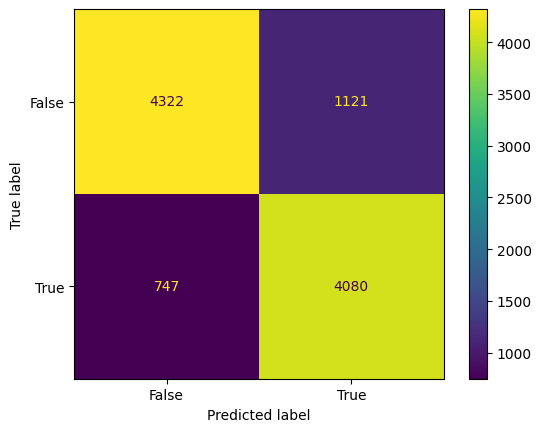

In [22]:
# Prec-recall one
threshold_f1 =  0.396133
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))


    Accuracy: 0.818 

    Balanced accuracy: 0.819 

    F1: 0.812 

    Precision: 0.787 

    Recall: 0.839 

    Sensitivity: 0.839 

    Specificity: 0.799 

    G-means: 0.819 

    


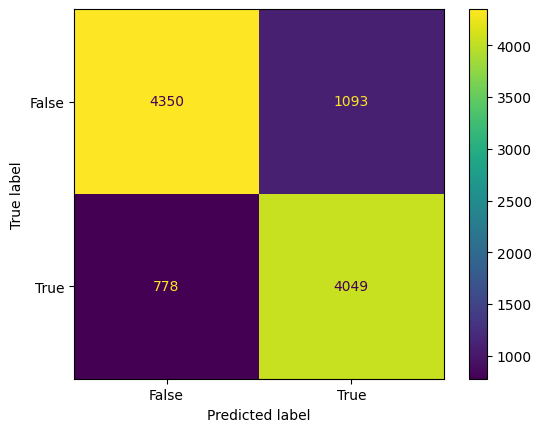

In [23]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 23
CNN_Long_Data2
Using  curated fnusa as training and curated mayo as val
Using Hilbert feature

Fnusa

max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1500
}

Mayo

max_img_subj_cat = {
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1300
}

In [6]:
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data2(n_classes=n_classes, input_size=input_size, input_length=6094)

In [7]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/2048Hz/trial_23/best_model.pt"))

<All keys matched successfully>

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((40326,), (40326,))

### ROC

Best Threshold=0.378481, G-Mean=0.811, Specificity=0.781, Sensitivity=0.843


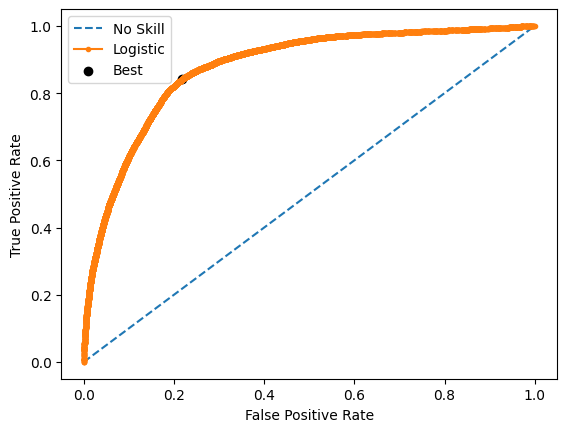

In [9]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.812 

    Balanced accuracy: 0.812 

    F1: 0.816 

    Precision: 0.791 

    Recall: 0.843 

    Sensitivity: 0.843 

    Specificity: 0.781 

    G-means: 0.811 

    


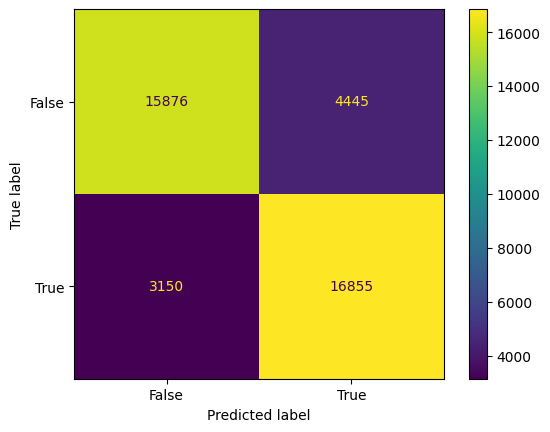

In [10]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1

Best Threshold=0.361756, F-Score=0.818, Recall:0.859, Precision:0.780


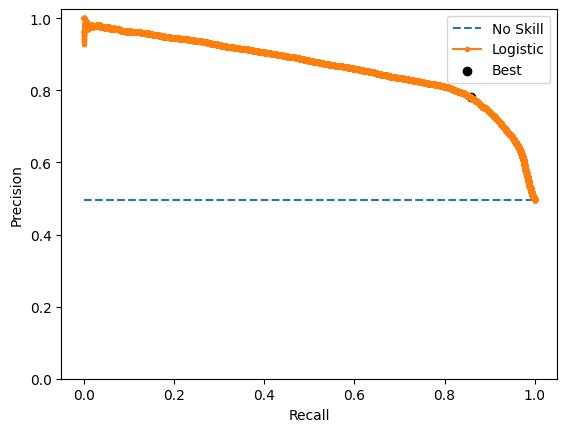

In [11]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.810 

    Balanced accuracy: 0.810 

    F1: 0.818 

    Precision: 0.780 

    Recall: 0.859 

    Sensitivity: 0.859 

    Specificity: 0.762 

    G-means: 0.809 

    


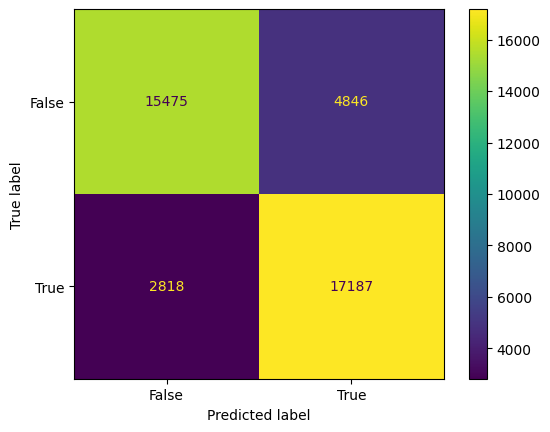

In [12]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Average


    Accuracy: 0.810 

    Balanced accuracy: 0.811 

    F1: 0.817 

    Precision: 0.785 

    Recall: 0.850 

    Sensitivity: 0.850 

    Specificity: 0.771 

    G-means: 0.810 

    


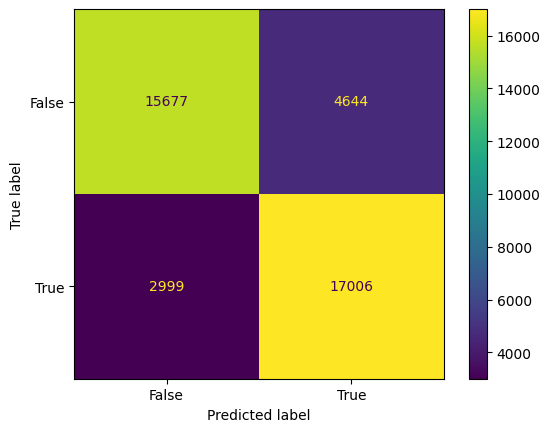

In [13]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 25
CNN_Long_Data2
Using  full fnusa as training and curated mayo as val
Using Hilbert feature

In [7]:
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data2(n_classes=n_classes, input_size=input_size, input_length=6094)

In [8]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/2048Hz/trial_25/best_model.pt"))

<All keys matched successfully>

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((40326,), (40326,))

### ROC

Best Threshold=0.174351, G-Mean=0.809, Specificity=0.795, Sensitivity=0.822


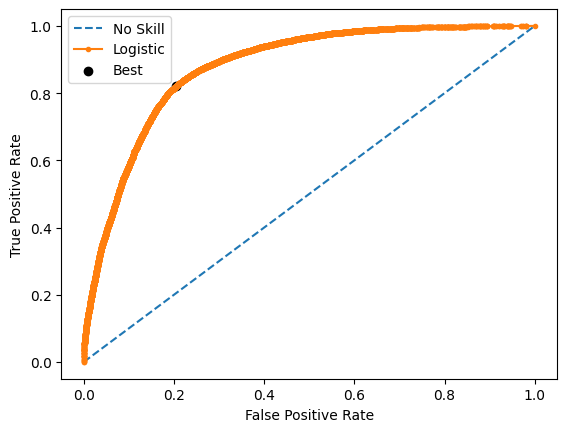

In [10]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.808 

    Balanced accuracy: 0.809 

    F1: 0.810 

    Precision: 0.798 

    Recall: 0.822 

    Sensitivity: 0.822 

    Specificity: 0.795 

    G-means: 0.808 

    


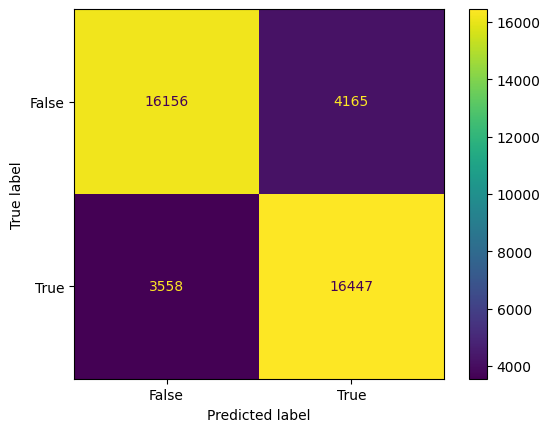

In [11]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1

Best Threshold=0.125021, F-Score=0.816, Recall:0.870, Precision:0.769


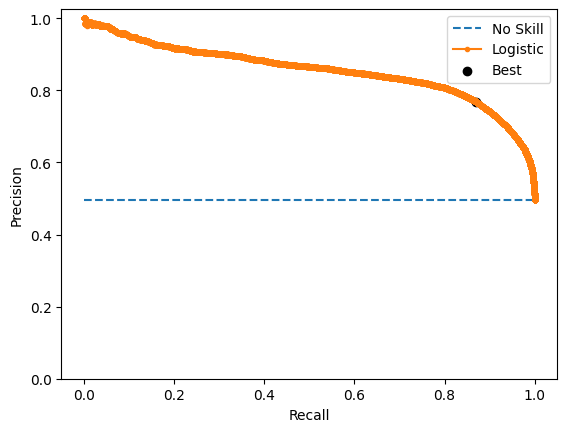

In [12]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.806 

    Balanced accuracy: 0.806 

    F1: 0.816 

    Precision: 0.769 

    Recall: 0.870 

    Sensitivity: 0.870 

    Specificity: 0.742 

    G-means: 0.804 

    


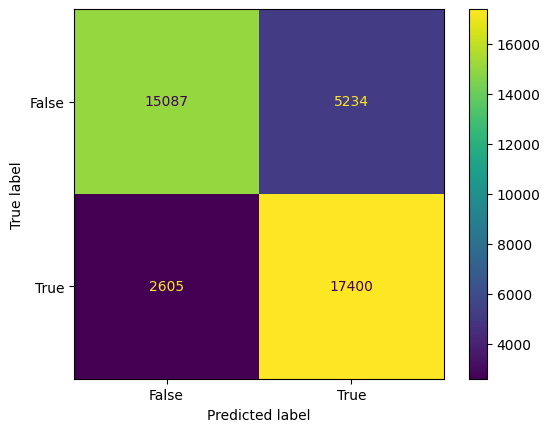

In [13]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Average


    Accuracy: 0.808 

    Balanced accuracy: 0.808 

    F1: 0.813 

    Precision: 0.786 

    Recall: 0.843 

    Sensitivity: 0.843 

    Specificity: 0.773 

    G-means: 0.808 

    


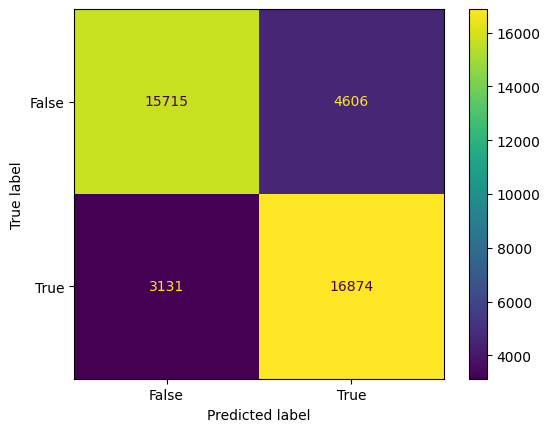

In [14]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 26
CNN_Long_Data2


Using  curated fnusa as training and curated mayo as val

Using Combined feature

Fnusa

max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1500
}

Mayo

max_img_subj_cat = {
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1300
}

In [23]:
n_classes = 1
input_size = 2
model_0 = model.CNN_Long_Data2(n_classes=n_classes, input_size=input_size, input_length=6094)

In [24]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/2048Hz/trial_26/best_model.pt"))

<All keys matched successfully>

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((40326,), (40326,))

### ROC

Best Threshold=0.405320, G-Mean=0.797, Specificity=0.760, Sensitivity=0.836


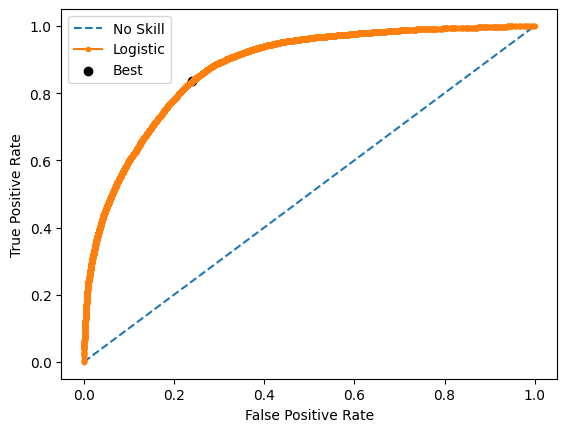

In [26]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.798 

    Balanced accuracy: 0.798 

    F1: 0.804 

    Precision: 0.774 

    Recall/Sensitivity: 0.836 

    Specificity: 0.760 

    G-means: 0.797 

    


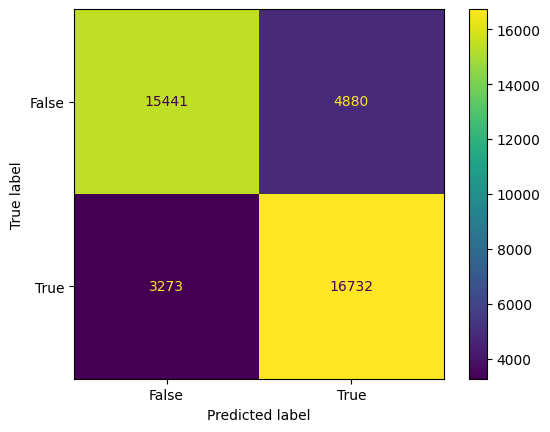

In [27]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1

Best Threshold=0.328896, F-Score=0.812, Recall:0.886, Precision:0.748


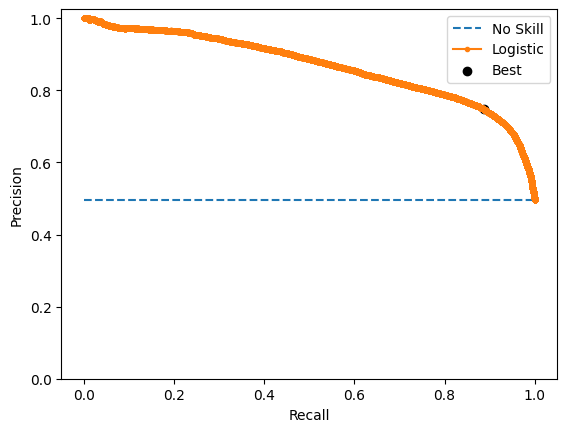

In [28]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.796 

    Balanced accuracy: 0.796 

    F1: 0.812 

    Precision: 0.748 

    Recall/Sensitivity: 0.886 

    Specificity: 0.707 

    G-means: 0.791 

    


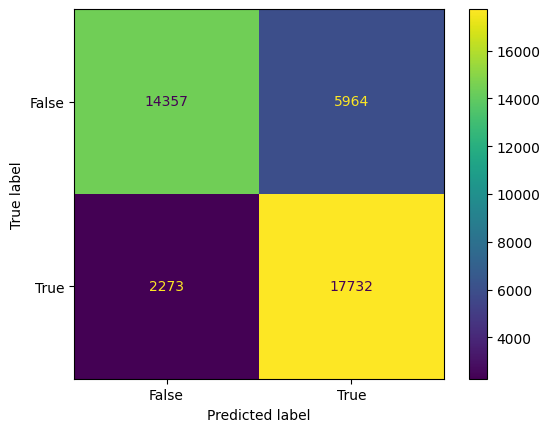

In [29]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Average


    Accuracy: 0.797 

    Balanced accuracy: 0.798 

    F1: 0.808 

    Precision: 0.762 

    Recall/Sensitivity: 0.861 

    Specificity: 0.734 

    G-means: 0.795 

    


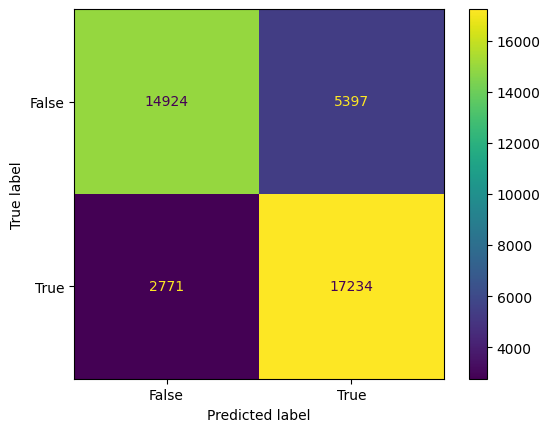

In [30]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 27
CNN_Long_Data3
Using  curated fnusa as training and curated mayo as val
Using Hilbert feature

Fnusa

max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1500
}

Mayo

max_img_subj_cat = {
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1300
}

In [6]:
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data3(n_classes=n_classes, input_size=input_size, input_length=6094)

In [7]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/2048Hz/trial_27/best_model.pt"))

<All keys matched successfully>

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((40326,), (40326,))

### ROC

Best Threshold=0.432444, G-Mean=0.818, Specificity=0.789, Sensitivity=0.849


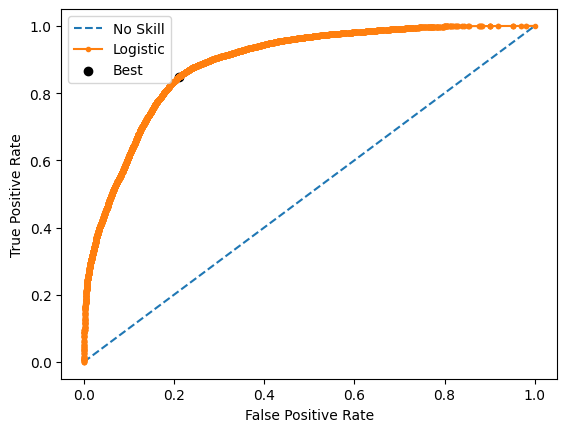

In [9]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.819 

    Balanced accuracy: 0.819 

    F1: 0.823 

    Precision: 0.798 

    Recall/Sensitivity: 0.849 

    Specificity: 0.789 

    G-means: 0.818 

    


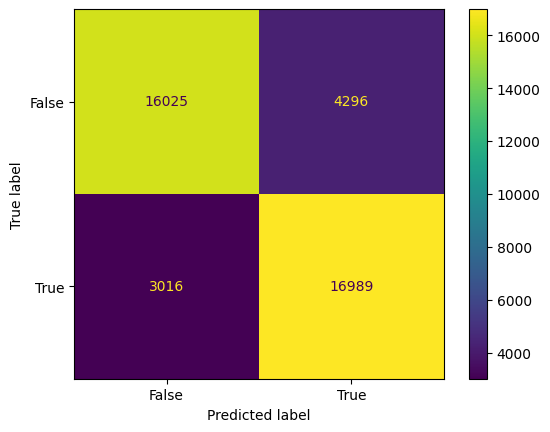

In [12]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1

Best Threshold=0.371594, F-Score=0.826, Recall:0.875, Precision:0.782


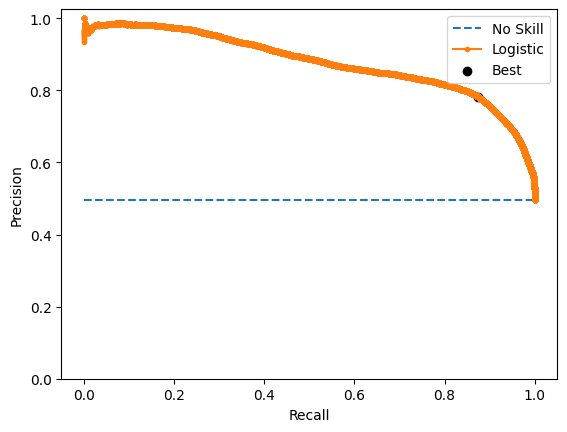

In [13]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.817 

    Balanced accuracy: 0.817 

    F1: 0.826 

    Precision: 0.782 

    Recall/Sensitivity: 0.875 

    Specificity: 0.760 

    G-means: 0.815 

    


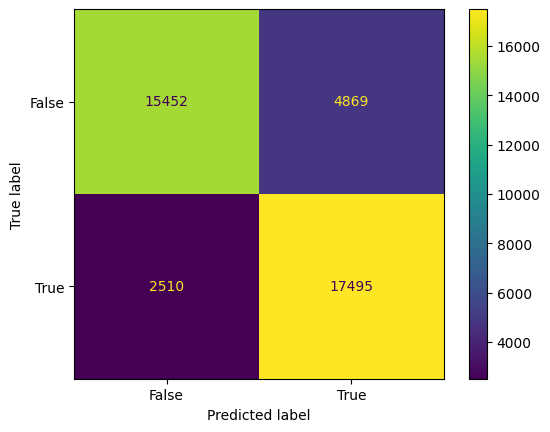

In [14]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Average


    Accuracy: 0.818 

    Balanced accuracy: 0.819 

    F1: 0.825 

    Precision: 0.791 

    Recall/Sensitivity: 0.862 

    Specificity: 0.775 

    G-means: 0.818 

    


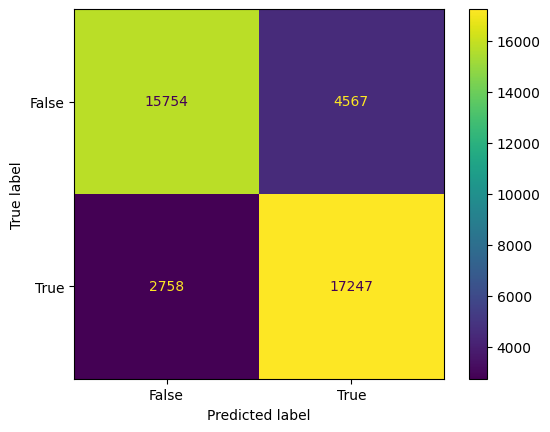

In [15]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 28
CNN_Long_Data3
Using  curated fnusa as training and curated mayo as val
Using combined feature

Fnusa

max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1500
}

Mayo

max_img_subj_cat = {
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1300
}

In [8]:
n_classes = 1
input_size = 2
model_0 = model.CNN_Long_Data3(n_classes=n_classes, input_size=input_size, input_length=6094)

In [9]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/2048Hz/trial_28/best_model.pt"))

<All keys matched successfully>

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((40326,), (40326,))

### ROC

Best Threshold=0.511181, G-Mean=0.810, Specificity=0.772, Sensitivity=0.851


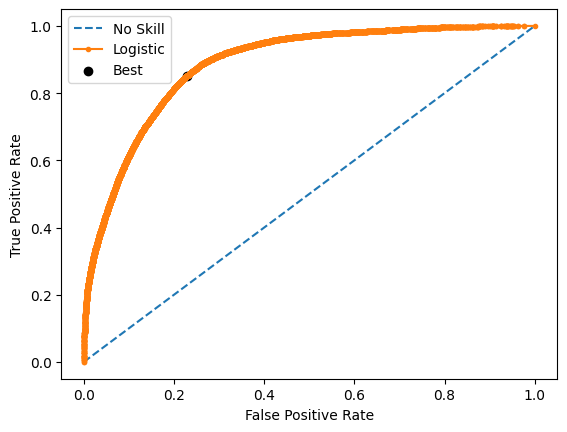

In [11]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.811 

    Balanced accuracy: 0.811 

    F1: 0.817 

    Precision: 0.786 

    Recall/Sensitivity: 0.851 

    Specificity: 0.772 

    G-means: 0.810 

    


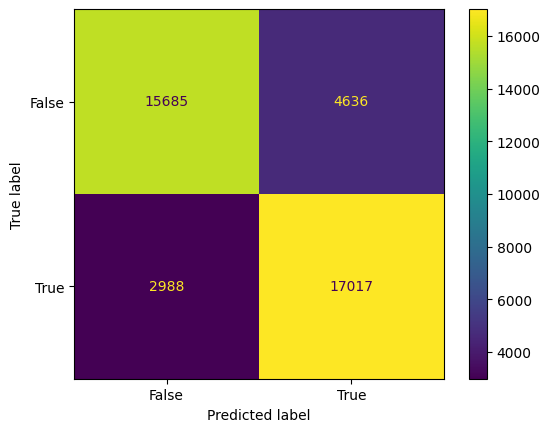

In [12]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1

Best Threshold=0.429957, F-Score=0.824, Recall:0.893, Precision:0.765


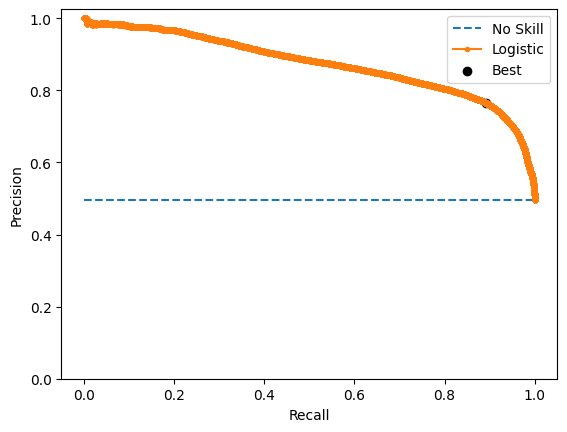

In [13]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.810 

    Balanced accuracy: 0.811 

    F1: 0.824 

    Precision: 0.765 

    Recall/Sensitivity: 0.892 

    Specificity: 0.730 

    G-means: 0.807 

    


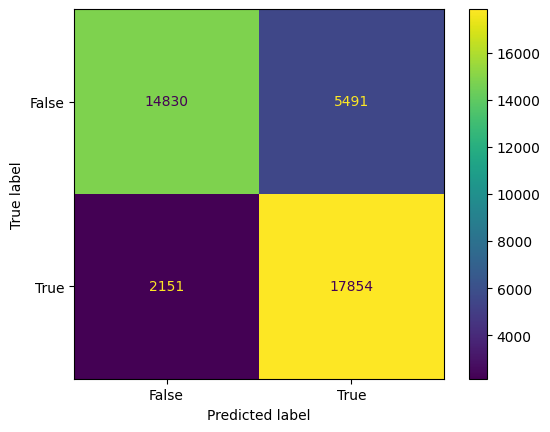

In [14]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Average


    Accuracy: 0.811 

    Balanced accuracy: 0.812 

    F1: 0.821 

    Precision: 0.775 

    Recall/Sensitivity: 0.873 

    Specificity: 0.750 

    G-means: 0.809 

    


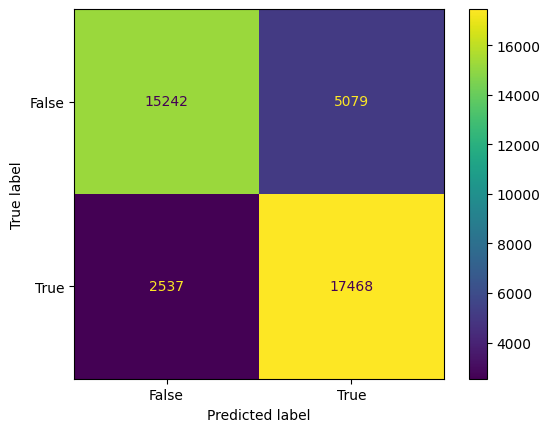

In [15]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 29
CNN_Long_Data5
Using  curated fnusa as training and curated mayo as val
Using Hilbert feature

Fnusa

max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1500
}

Mayo

max_img_subj_cat = {
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1300
}

In [18]:
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data5(n_classes=n_classes, input_size=input_size, input_length=6094)

In [19]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/2048Hz/trial_29/best_model.pt"))

<All keys matched successfully>

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((40326,), (40326,))

### ROC

Best Threshold=0.502976, G-Mean=0.816, Specificity=0.793, Sensitivity=0.840


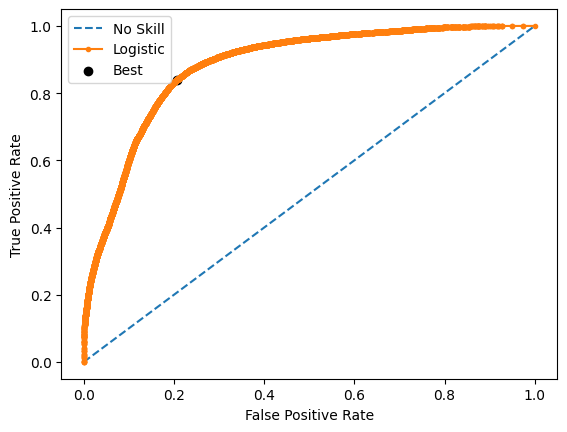

In [21]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.811 

    Balanced accuracy: 0.811 

    F1: 0.817 

    Precision: 0.786 

    Recall/Sensitivity: 0.851 

    Specificity: 0.772 

    G-means: 0.810 

    


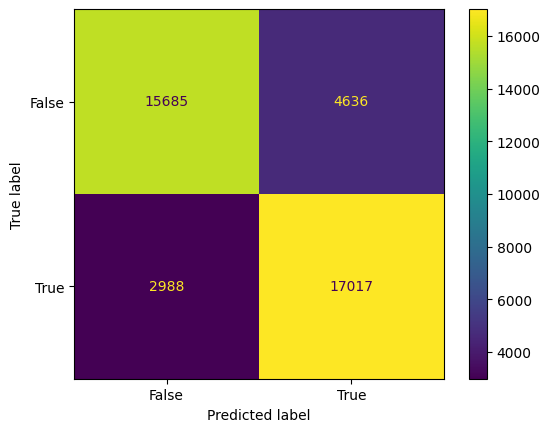

In [12]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1

Best Threshold=0.437496, F-Score=0.824, Recall:0.870, Precision:0.783


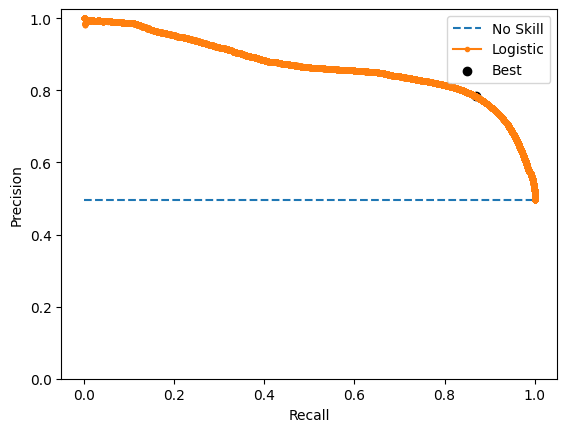

In [22]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.810 

    Balanced accuracy: 0.811 

    F1: 0.824 

    Precision: 0.765 

    Recall/Sensitivity: 0.892 

    Specificity: 0.730 

    G-means: 0.807 

    


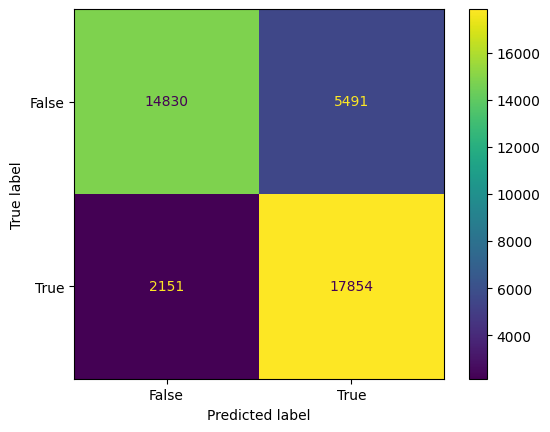

In [14]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Average


    Accuracy: 0.816 

    Balanced accuracy: 0.816 

    F1: 0.822 

    Precision: 0.791 

    Recall/Sensitivity: 0.855 

    Specificity: 0.778 

    G-means: 0.816 

    


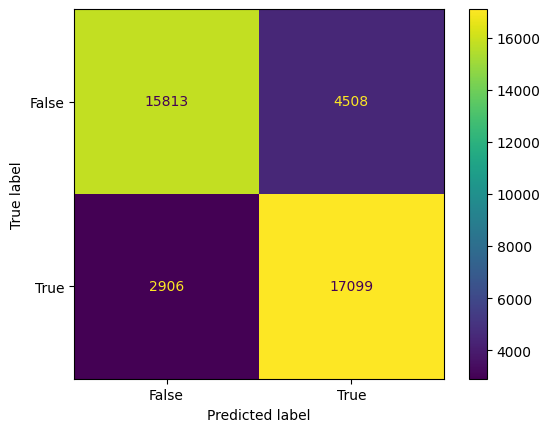

In [23]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 13
CNN_Long_Data2
Using dataframe: /scratch/mcesped/Datasets/Noise_detection/df_train_curated.csv

Using zipfiles: ['/home/mcesped/scratch/Datasets/2048Hz/Dataset_Fnusa_Combined.zip', '/home/mcesped/scratch/Datasets/2048Hz/Dataset_Mayo_Combined.zip']

In [30]:
n_classes = 1
input_size = 2
model_0 = model.CNN_Long_Data2(n_classes=n_classes, input_size=input_size, input_length=6094)

In [31]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/2048Hz/trial_13/best_model.pt"))

<All keys matched successfully>

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((10270,), (10270,))

### ROC

Best Threshold=0.359147, G-Mean=0.777, Specificity=0.854, Sensitivity=0.706


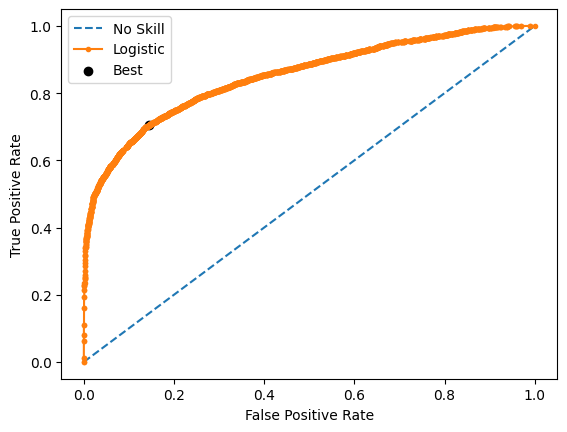

In [34]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.785 

    Balanced accuracy: 0.780 

    F1: 0.755 

    Precision: 0.811 

    Recall: 0.706 

    Sensitivity: 0.706 

    Specificity: 0.854 

    G-means: 0.777 

    


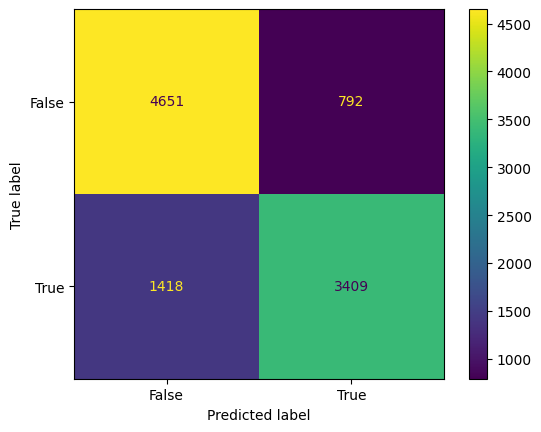

In [35]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1 curve

Best Threshold=0.275257, F-Score=0.759, Recall:0.785, Precision:0.735


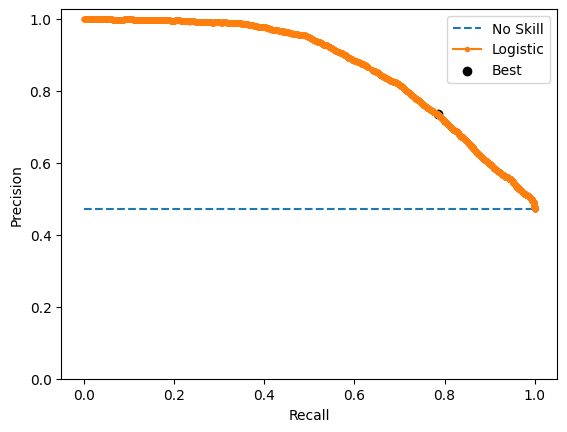

In [36]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.766 

    Balanced accuracy: 0.767 

    F1: 0.759 

    Precision: 0.735 

    Recall: 0.785 

    Sensitivity: 0.785 

    Specificity: 0.749 

    G-means: 0.767 

    


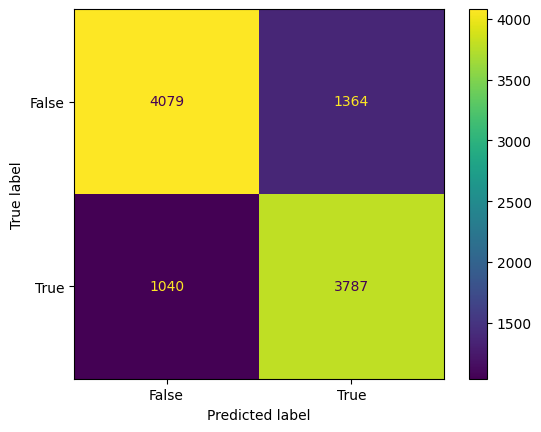

In [37]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Optimal threshold


    Accuracy: 0.775 

    Balanced accuracy: 0.774 

    F1: 0.757 

    Precision: 0.770 

    Recall: 0.745 

    Sensitivity: 0.745 

    Specificity: 0.802 

    G-means: 0.773 

    


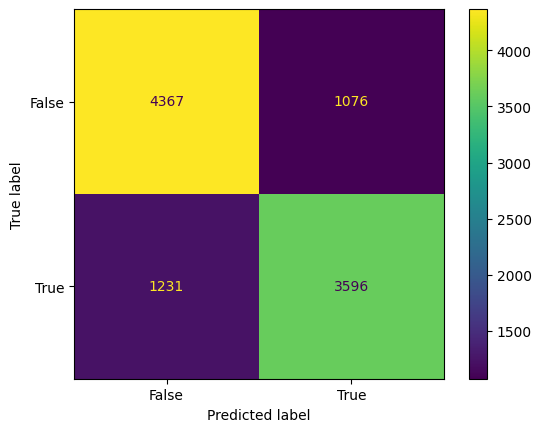

In [38]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

# Path detection 2048 Hz

In [17]:
# load dataset
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [20]:
# Zip files and transforms
features = 'Hilbert'
srate=2048
zip_files = [
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Fnusa_Combined.zip",
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Mayo_Combined.zip",
]
df_train_path = '/scratch/mcesped/Datasets/Pathology_detection/df_train_curated.csv'
df_val_path = '/scratch/mcesped/Datasets/Pathology_detection/df_val_curated.csv'

In [21]:
(
        train_dataloader,
        val_dataloader,
        _,
    ) = data_setup.create_dataloaders_uncompress(
        zip_files,
        df_train_path,
        df_val_path,
        None,
        None,
        batch_size=32,
        num_workers=4,
        dataset_class="SpectrogramDir",
        binary=True,
        previosly_uncompressed = True,
        features=features,
        binary_cat='Pathology'
    )
train_dataloader, val_dataloader 

Percentage df train: 0.718590407647711

Grouping Noise and Physiology in one class


Creating dataset classes...


(<torch.utils.data.dataloader.DataLoader at 0x2b49cc228910>,
 <torch.utils.data.dataloader.DataLoader at 0x2b49ccf09b40>)

In [22]:
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data3(n_classes=n_classes, input_size=input_size, input_length=6094)

In [23]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Pathology_detection/2048Hz/trial_1/best_model.pt"))

<All keys matched successfully>

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((30968,), (30968,))

### ROC

Best Threshold=0.396817, G-Mean=0.918, Specificity=0.917, Sensitivity=0.918


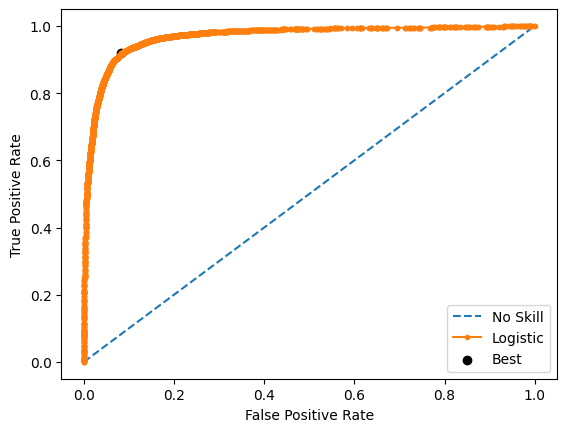

In [26]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.917 

    Balanced accuracy: 0.918 

    F1: 0.907 

    Precision: 0.896 

    Recall/Sensitivity: 0.918 

    Specificity: 0.917 

    G-means: 0.918 

    


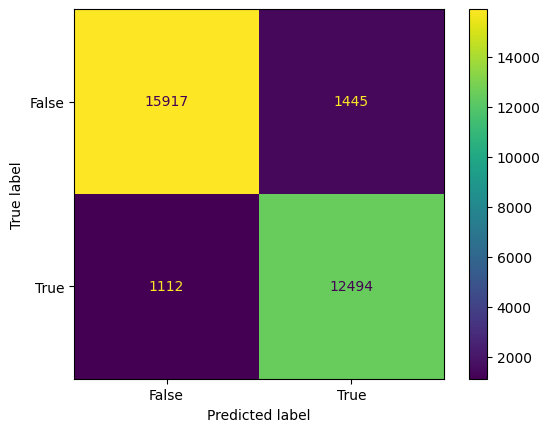

In [27]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1 curve

Best Threshold=0.396817, F-Score=0.907, Recall:0.918, Precision:0.896


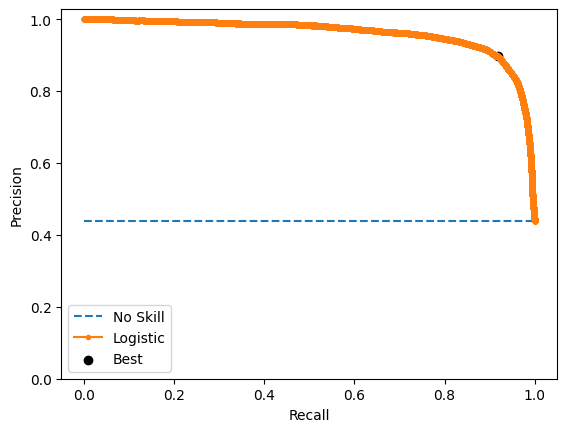

In [28]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.917 

    Balanced accuracy: 0.918 

    F1: 0.907 

    Precision: 0.896 

    Recall/Sensitivity: 0.918 

    Specificity: 0.917 

    G-means: 0.918 

    


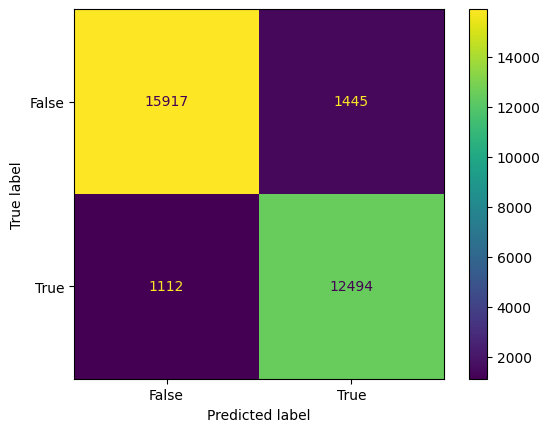

In [29]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Optimal threshold


    Accuracy: 0.917 

    Balanced accuracy: 0.918 

    F1: 0.907 

    Precision: 0.896 

    Recall/Sensitivity: 0.918 

    Specificity: 0.917 

    G-means: 0.918 

    


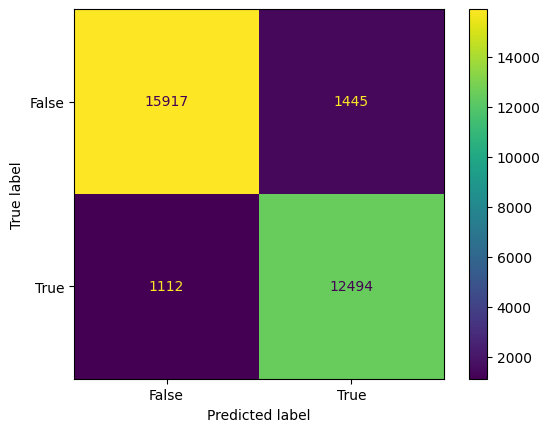

In [30]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

# OVR 2048 Hz

## Balanced case

### Noise model

In [29]:
# load dataset
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

# Zip files and transforms
features = 'Hilbert'
srate=2048
zip_files = [
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Fnusa_Combined.zip",
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Mayo_Combined.zip",
]

# Using multiclass data
df_train_path = '/scratch/mcesped/Datasets/Multiclass/df_train_curated.csv'
df_val_path = '/scratch/mcesped/Datasets/Multiclass/df_val_curated_OVR.csv'

(
        train_dataloader,
        val_dataloader,
        _,
    ) = data_setup.create_dataloaders_uncompress(
        zip_files,
        df_train_path,
        df_val_path,
        None,
        None,
        batch_size=32,
        num_workers=4,
        dataset_class="SpectrogramDir",
        binary=True,
        previosly_uncompressed = True,
        features=features,
        binary_cat='Noise'
    )
train_dataloader, val_dataloader 

Percentage df train: 0.5875736475629352

Grouping Pathology and Physiology in one class


Creating dataset classes...


(<torch.utils.data.dataloader.DataLoader at 0x2ad1f01d15a0>,
 <torch.utils.data.dataloader.DataLoader at 0x2ad1f090ab30>)

In [30]:
# Noise model
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data3(n_classes=n_classes, input_size=input_size, input_length=6094)

model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/2048Hz/trial_27/best_model.pt"))

device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_pred_noise = y_pred_total

### Pathological model

In [31]:
# load dataset
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

# Zip files and transforms
features = 'Hilbert'
srate=2048
zip_files = [
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Fnusa_Combined.zip",
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Mayo_Combined.zip",
]

# Using multiclass data
df_train_path = '/scratch/mcesped/Datasets/Multiclass/df_train_curated.csv'
df_val_path = '/scratch/mcesped/Datasets/Multiclass/df_val_curated_OVR.csv'

(
        train_dataloader,
        val_dataloader,
        _,
    ) = data_setup.create_dataloaders_uncompress(
        zip_files,
        df_train_path,
        df_val_path,
        None,
        None,
        batch_size=32,
        num_workers=4,
        dataset_class="SpectrogramDir",
        binary=True,
        previosly_uncompressed = True,
        features=features,
        binary_cat='Pathology'
    )
train_dataloader, val_dataloader 

Percentage df train: 0.5875736475629352

Grouping Noise and Physiology in one class


Creating dataset classes...


(<torch.utils.data.dataloader.DataLoader at 0x2ad1f048e080>,
 <torch.utils.data.dataloader.DataLoader at 0x2ad1f048d720>)

In [32]:
# Path model
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data3(n_classes=n_classes, input_size=input_size, input_length=6094)

model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Pathology_detection/2048Hz/trial_1/best_model.pt"))

device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_pred_path = y_pred_total

### Merge them

In [33]:
threshold_noise = (0.371594+0.432444)/2
threshold_path = (0.396817+0.396817)/2

# concat_y_pred = np.vstack([(y_pred_noise > threshold_noise).astype(int), (y_pred_path > threshold_path).astype(int)])
concat_y_pred = np.vstack([y_pred_noise, y_pred_path])

concat_y_pred.shape

(2, 43120)

In [34]:
np.save('ovr_pred.npy', concat_y_pred)

In [8]:
concat_y_pred = np.load('ovr_pred.npy')
y_pred_noise = concat_y_pred[0,:].squeeze()
y_pred_path = concat_y_pred[1,:].squeeze()
threshold_noise = (0.371594+0.432444)/2
threshold_path = (0.396817+0.396817)/2
concat_y_pred.shape

(2, 43120)

In [35]:
np.unique((y_pred_noise > threshold_noise).astype(int), return_counts=True)

(array([0, 1]), array([24728, 18392]))

In [36]:
merged_y_pred = classify_matrix(concat_y_pred.T, threshold_noise, threshold_path).astype(int)
merged_y_pred[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [37]:
np.unique(merged_y_pred, return_counts=True)

(array([0, 1, 2]), array([17801, 14757, 10562]))

In [10]:
# Get true y
import pandas as pd
df_val_path = '/scratch/mcesped/Datasets/Multiclass/df_val_curated_OVR.csv'
df_val = pd.read_csv(df_val_path, sep=',')
df_val.head()

,index,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
0,0,NaN,0,RMacro_08,depth,mayo,0,3,x002631,0,noise
1,1,NaN,0,RMacro_04,depth,mayo,0,3,x001483,1,noise
2,2,NaN,0,LMacro_01,depth,mayo,0,1,x000038,1,noise
3,3,NaN,0,RMacro_08,depth,mayo,0,3,x002612,0,noise
4,4,NaN,0,LMacro_07,depth,mayo,0,1,x000931,0,noise


In [11]:
y_true = df_val.category_id.values
y_true[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
np.unique(y_true,return_counts=True)

(array([0, 1, 2]), array([14705, 13953, 14462]))

In [41]:
import sklearn.metrics as skm


In [42]:
map_cat = {
    0: 'Noise',
    1: 'Pathology',
    2: 'Physiology'
}
for cat in np.unique(y_true):
    print(f"\nMetrics for {map_cat[cat]}:\n", flush=True)
    y_true_tmp = (y_true==cat).astype(int)
    y_pred_tmp = (merged_y_pred==cat).astype(int)
    # Metrics
    acc = skm.accuracy_score(y_true_tmp, y_pred_tmp)
    balanced_acc = skm.balanced_accuracy_score(y_true_tmp, y_pred_tmp)
    prec = skm.precision_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
    # Recall
    recall = skm.recall_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
    # F1
    f1 = skm.f1_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
    print(
        "\n-------------------- Key Metrics --------------------", end="\n", flush=True
    )
    print("\nAccuracy: {:.2f}".format(acc), end="\n", flush=True)
    print("Balanced Accuracy: {:.2f}\n".format(balanced_acc), end="\n", flush=True)

    print("Precision: {:.2f}".format(prec), end="\n", flush=True)
    print("Recall: {:.2f}".format(recall), end="\n", flush=True)
    print("F1-score: {:.2f}\n".format(f1), end="\n", flush=True)


Metrics for Noise:


-------------------- Key Metrics --------------------

Accuracy: 0.81
Balanced Accuracy: 0.82

Precision: 0.69
Recall: 0.83
F1-score: 0.75


Metrics for Pathology:


-------------------- Key Metrics --------------------

Accuracy: 0.93
Balanced Accuracy: 0.93

Precision: 0.87
Recall: 0.92
F1-score: 0.90


Metrics for Physiology:


-------------------- Key Metrics --------------------

Accuracy: 0.79
Balanced Accuracy: 0.73

Precision: 0.75
Recall: 0.55
F1-score: 0.63



In [17]:
(0.75+0.9+0.63)/3

0.7599999999999999

In [15]:
# Only noise model
# total metrics

map_cat = {
    0: 'Noise',
    1: 'Pathology',
    2: 'Physiology'
}
y_true_tmp = (y_true==0).astype(int)
print(f"\nMetrics for complete dataset:\n", flush=True)
y_pred_tmp = (y_pred_noise > threshold_noise).astype(int)
# Metrics
acc = skm.accuracy_score(y_true_tmp, y_pred_tmp)
balanced_acc = skm.balanced_accuracy_score(y_true_tmp, y_pred_tmp)
prec = skm.precision_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
# Recall
recall = skm.recall_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
# F1
f1 = skm.f1_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
print(
    "\n-------------------- Key Metrics --------------------", end="\n", flush=True
)
print("\nAccuracy: {:.2f}".format(acc), end="\n", flush=True)
print("Balanced Accuracy: {:.2f}\n".format(balanced_acc), end="\n", flush=True)

print("Precision: {:.2f}".format(prec), end="\n", flush=True)
print("Recall: {:.2f}".format(recall), end="\n", flush=True)
print("F1-score: {:.2f}\n".format(f1), end="\n", flush=True)

for cat in [1,2]:
    print(f"\nMetrics for {map_cat[cat]} vs Noise:\n", flush=True)
    bool_y = (y_true==cat).astype(bool) + (y_true==0).astype(bool)
    y_noise_thr = (y_pred_noise > threshold_noise).astype(int)
    y_true_tmp = (~(y_true[bool_y]==cat)).astype(int)
    y_pred_tmp = (y_noise_thr[bool_y]).astype(int)
    # Metrics
    acc = skm.accuracy_score(y_true_tmp, y_pred_tmp)
    balanced_acc = skm.balanced_accuracy_score(y_true_tmp, y_pred_tmp)
    prec = skm.precision_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
    # Recall
    recall = skm.recall_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
    # F1
    f1 = skm.f1_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
    print(
        "\n-------------------- Key Metrics --------------------", end="\n", flush=True
    )
    print("\nAccuracy: {:.2f}".format(acc), end="\n", flush=True)
    print("Balanced Accuracy: {:.2f}\n".format(balanced_acc), end="\n", flush=True)

    print("Precision: {:.2f}".format(prec), end="\n", flush=True)
    print("Recall: {:.2f}".format(recall), end="\n", flush=True)
    print("F1-score: {:.2f}\n".format(f1), end="\n", flush=True)


Metrics for complete dataset:


-------------------- Key Metrics --------------------

Accuracy: 0.81
Balanced Accuracy: 0.82

Precision: 0.68
Recall: 0.85
F1-score: 0.76


Metrics for Pathology vs Noise:


-------------------- Key Metrics --------------------

Accuracy: 0.90
Balanced Accuracy: 0.90

Precision: 0.95
Recall: 0.85
F1-score: 0.90


Metrics for Physiology vs Noise:


-------------------- Key Metrics --------------------

Accuracy: 0.75
Balanced Accuracy: 0.74

Precision: 0.71
Recall: 0.85
F1-score: 0.77



In [90]:
# Only path model
map_cat = {
    0: 'Noise',
    1: 'Pathology',
    2: 'Physiology'
}
for cat in [0,2]:
    print(f"\nMetrics for {map_cat[cat]} vs Pathology:\n", flush=True)
    bool_y = (y_true==cat).astype(bool) + (y_true==1).astype(bool)
    y_thr = (y_pred_path > threshold_path).astype(int)
    y_true_tmp = (~(y_true[bool_y]==cat)).astype(int)
    y_pred_tmp = (y_thr[bool_y]).astype(int)
    # Metrics
    acc = skm.accuracy_score(y_true_tmp, y_pred_tmp)
    balanced_acc = skm.balanced_accuracy_score(y_true_tmp, y_pred_tmp)
    prec = skm.precision_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
    # Recall
    recall = skm.recall_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
    # F1
    f1 = skm.f1_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
    print(
        "\n-------------------- Key Metrics --------------------", end="\n", flush=True
    )
    print("\nAccuracy: {:.2f}".format(acc), end="\n", flush=True)
    print("Balanced Accuracy: {:.2f}\n".format(balanced_acc), end="\n", flush=True)

    print("Precision: {:.2f}".format(prec), end="\n", flush=True)
    print("Recall: {:.2f}".format(recall), end="\n", flush=True)
    print("F1-score: {:.2f}\n".format(f1), end="\n", flush=True)


Metrics for Noise vs Pathology:


-------------------- Key Metrics --------------------

Accuracy: 0.93
Balanced Accuracy: 0.93

Precision: 0.91
Recall: 0.93
F1-score: 0.92


Metrics for Physiology vs Pathology:


-------------------- Key Metrics --------------------

Accuracy: 0.91
Balanced Accuracy: 0.92

Precision: 0.89
Recall: 0.93
F1-score: 0.91



## Imbalanced case

### Noise model

In [43]:
# load dataset
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

# Zip files and transforms
features = 'Hilbert'
srate=2048
zip_files = [
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Fnusa_Combined.zip",
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Mayo_Combined.zip",
]

# Using multiclass data
df_train_path = '/scratch/mcesped/Datasets/Multiclass/df_train_curated.csv'
df_val_path = '/scratch/mcesped/Datasets/Multiclass/df_val_curated_OVR_imbalanced.csv'

(
        train_dataloader,
        val_dataloader,
        _,
    ) = data_setup.create_dataloaders_uncompress(
        zip_files,
        df_train_path,
        df_val_path,
        None,
        None,
        batch_size=32,
        num_workers=4,
        dataset_class="SpectrogramDir",
        binary=True,
        previosly_uncompressed = True,
        features=features,
        binary_cat='Noise'
    )
train_dataloader, val_dataloader 

Percentage df train: 0.5177275676951212

Grouping Pathology and Physiology in one class


Creating dataset classes...


(<torch.utils.data.dataloader.DataLoader at 0x2ad1f0379f60>,
 <torch.utils.data.dataloader.DataLoader at 0x2ad1f091bc70>)

In [44]:
# Noise model
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data3(n_classes=n_classes, input_size=input_size, input_length=6094)

model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/2048Hz/trial_27/best_model.pt"))

device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_pred_noise = y_pred_total

### Pathological model

In [45]:
# load dataset
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

# Zip files and transforms
features = 'Hilbert'
srate=2048
zip_files = [
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Fnusa_Combined.zip",
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Mayo_Combined.zip",
]

# Using multiclass data
df_train_path = '/scratch/mcesped/Datasets/Multiclass/df_train_curated.csv'
df_val_path = '/scratch/mcesped/Datasets/Multiclass/df_val_curated_OVR_imbalanced.csv'

(
        train_dataloader,
        val_dataloader,
        _,
    ) = data_setup.create_dataloaders_uncompress(
        zip_files,
        df_train_path,
        df_val_path,
        None,
        None,
        batch_size=32,
        num_workers=4,
        dataset_class="SpectrogramDir",
        binary=True,
        previosly_uncompressed = True,
        features=features,
        binary_cat='Pathology'
    )
train_dataloader, val_dataloader 

Percentage df train: 0.5177275676951212

Grouping Noise and Physiology in one class


Creating dataset classes...


(<torch.utils.data.dataloader.DataLoader at 0x2ad1f090b3d0>,
 <torch.utils.data.dataloader.DataLoader at 0x2ad1f048ea70>)

In [46]:
# Path model
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data3(n_classes=n_classes, input_size=input_size, input_length=6094)

model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Pathology_detection/2048Hz/trial_1/best_model.pt"))

device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_pred_path = y_pred_total

### Merge them

In [47]:
threshold_noise = (0.371594+0.432444)/2
threshold_path = (0.396817+0.396817)/2

# concat_y_pred = np.vstack([(y_pred_noise > threshold_noise).astype(int), (y_pred_path > threshold_path).astype(int)])
concat_y_pred = np.vstack([y_pred_noise, y_pred_path])

concat_y_pred.shape

(2, 57225)

In [48]:
np.save('ovr_pred_imbalanced.npy', concat_y_pred)

In [49]:
np.unique((y_pred_noise > threshold_noise).astype(int), return_counts=True)

(array([0, 1]), array([34537, 22688]))

In [50]:
merged_y_pred = classify_matrix(concat_y_pred.T, threshold_noise, threshold_path).astype(int)
merged_y_pred[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
np.unique(merged_y_pred, return_counts=True)

(array([0, 1, 2]), array([22056, 16417, 18752]))

In [52]:
# Get true y
import pandas as pd
df_val_path = '/scratch/mcesped/Datasets/Multiclass/df_val_curated_OVR_imbalanced.csv'
df_val = pd.read_csv(df_val_path, sep=',')
df_val.head()

,index,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
0,0,NaN,0,LMacro_01,depth,mayo,0,1,x000285,1,noise
1,1,NaN,0,LMacro_05,depth,mayo,0,3,x000793,1,noise
2,2,NaN,0,RMacro_05,depth,mayo,0,1,x001521,0,noise
3,3,NaN,0,RMacro_06,depth,mayo,0,1,x001898,0,noise
4,4,NaN,0,LMacro_01,depth,mayo,0,1,x000480,1,noise


In [53]:
y_true = df_val.category_id.values
y_true[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
np.unique(y_true,return_counts=True)

(array([0, 1, 2]), array([13827, 13953, 29445]))

In [25]:
import sklearn.metrics as skm


In [55]:
map_cat = {
    0: 'Noise',
    1: 'Pathology',
    2: 'Physiology'
}
for cat in np.unique(y_true):
    print(f"\nMetrics for {map_cat[cat]}:\n", flush=True)
    y_true_tmp = (y_true==cat).astype(int)
    y_pred_tmp = (merged_y_pred==cat).astype(int)
    # Metrics
    acc = skm.accuracy_score(y_true_tmp, y_pred_tmp)
    balanced_acc = skm.balanced_accuracy_score(y_true_tmp, y_pred_tmp)
    prec = skm.precision_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
    # Recall
    recall = skm.recall_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
    # F1
    f1 = skm.f1_score(y_true_tmp, y_pred_tmp, average="binary", zero_division=0.0)
    print(
        "\n-------------------- Key Metrics --------------------", end="\n", flush=True
    )
    print("\nAccuracy: {:.2f}".format(acc), end="\n", flush=True)
    print("Balanced Accuracy: {:.2f}\n".format(balanced_acc), end="\n", flush=True)

    print("Precision: {:.2f}".format(prec), end="\n", flush=True)
    print("Recall: {:.2f}".format(recall), end="\n", flush=True)
    print("F1-score: {:.2f}\n".format(f1), end="\n", flush=True)


Metrics for Noise:


-------------------- Key Metrics --------------------

Accuracy: 0.77
Balanced Accuracy: 0.79

Precision: 0.52
Recall: 0.83
F1-score: 0.64


Metrics for Pathology:


-------------------- Key Metrics --------------------

Accuracy: 0.92
Balanced Accuracy: 0.92

Precision: 0.78
Recall: 0.92
F1-score: 0.85


Metrics for Physiology:


-------------------- Key Metrics --------------------

Accuracy: 0.72
Balanced Accuracy: 0.73

Precision: 0.86
Recall: 0.55
F1-score: 0.67

